In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [98]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [99]:
# loading dataset
data_dictionary = "ML project 2025/heloc_data_dictionary-2.xlsx"

df = pd.read_csv('heloc_dataset_v1.csv')
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


In [100]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

In [101]:
# check the missing values
n_cols_with_missing_values = df.isnull().any(axis=0).sum()

n_rows_with_missing_ExternalRiskEstimate_values = df['ExternalRiskEstimate'].isnull().sum()

print(n_cols_with_missing_values)
print(n_rows_with_missing_ExternalRiskEstimate_values)

0
0


In [102]:
col_names = df.columns.tolist()

cols_numeric = [cols for cols in col_names if df[cols].dtype in ['int64', 'float64']]
cols_string = [cols for cols in col_names if df[cols].dtype == 'object']

print(cols_numeric)
print(cols_string)

['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance']
['RiskPerformance']


In [103]:
df = df[~df.isin([-9]).any(axis=1)]

In [104]:
group_mean_7 = df.replace([-7,-8], np.nan).groupby('RiskPerformance').mean()
group_mean_7

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
RiskPerformance,,,,,,,,,,,,,,,,,,,,,
Bad,67.694423,180.493299,8.880850,70.714899,19.598089,0.781786,0.516771,89.446568,18.857999,5.384555,...,37.010920,1.596778,1.749610,1.673947,44.842728,70.202040,4.486616,2.563978,1.463596,72.372070
Good,76.790830,222.815055,10.213607,87.443693,22.790619,0.362561,0.239594,95.514473,27.057589,6.162899,...,31.974012,3.433306,1.136911,1.096345,24.269747,66.506164,3.692733,2.397565,0.709445,60.049683


In [105]:
# Function to impute -7 with group means based on Risk_Performance
def impute_with_group_mean(row):
    for col in df.columns:
        if col == 'RiskPerformance' or not np.issubdtype(df[col].dtype, np.number):
            continue
        # Replace -7 with the corresponding group's mean
        if row[col] == -7:
            row[col] = -8
        # Replace -8 with the corresponding group's mean
        if row[col] == -8:
            row[col] = group_mean_7.loc[row['RiskPerformance'], col]
    return row

# Apply the function row by row
df = df.apply(impute_with_group_mean, axis=1)

In [106]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
num_duplicates

1

In [107]:
duplicate_rows = df[duplicates]
duplicate_rows

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
5424,Bad,64,242.0,18,124,16,2,0,47,2.0,...,74,0.0,4,4,27.0,70.20204,2.0,3.0,0.0,100.0


In [108]:
df = df.drop_duplicates()

In [109]:
label_encoder = LabelEncoder()

# Separate features and target variable
selected = ['MSinceMostRecentDelq', 'MaxDelqEver', 'ExternalRiskEstimate', 'PercentTradesNeverDelq','MSinceMostRecentInqexcl7days']
X = df[selected]
#X = df.drop(columns=['RiskPerformance'])
y = label_encoder.fit_transform(df['RiskPerformance'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [110]:
# Apply Lasso regression with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

LassoCV(cv=5, random_state=42)

In [111]:
# Extract feature importance
lasso_importance = pd.Series(lasso.coef_, index=X.columns)
important_features = lasso_importance[lasso_importance != 0].sort_values(ascending=False)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

LassoCV(cv=5, random_state=42)

In [112]:
# Extract feature importance
lasso_importance = pd.Series(lasso.coef_, index=X.columns)

In [113]:
# Print the top 10 most important features
top_n = 24
print(f"Top {top_n} Important Features Based on Lasso Regression:")
print(important_features.head(top_n))

Top 24 Important Features Based on Lasso Regression:
ExternalRiskEstimate            0.189085
MSinceMostRecentInqexcl7days    0.065456
MSinceMostRecentDelq            0.059734
PercentTradesNeverDelq          0.009724
dtype: float64


In [114]:
# Class Imbalance
counts = df["RiskPerformance"].value_counts()
print("Counts of 'Bad' vs 'Good':")
print(counts)

Counts of 'Bad' vs 'Good':
RiskPerformance
Bad     5127
Good    4733
Name: count, dtype: int64


In [115]:
from sklearn.model_selection import train_test_split

# Step 2: Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

# New class distribution
print("Resampled class distribution:", Counter(y_train_s))

Resampled class distribution: Counter({0: 4094, 1: 4094})


In [116]:
rows=df.shape[0]
rows

9860

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

### Model training and evaluation

After preprocessed the data, now we can start training 3 models: classification tree, logistic regression, and K-nearest neighbors.

We will use 2 methods for evaluation: validation set as simple cross validation and cross-validation

Logistic Regression Model

In [118]:
log_reg=LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_s, y_train_s)

# Make predictions
y_pred = log_reg.predict(X_test)


In [119]:
log_accuracy = accuracy_score(y_test, y_pred)
log_precision = precision_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_f1 = f1_score(y_test, y_pred)

print("🔍 Model Performance Metrics:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"F1 Score: {log_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

🔍 Model Performance Metrics:
Accuracy: 0.7241
Precision: 0.7026
Recall: 0.7295
F1 Score: 0.7158

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.73      1033
           1       0.70      0.73      0.72       939

    accuracy                           0.72      1972
   macro avg       0.72      0.72      0.72      1972
weighted avg       0.72      0.72      0.72      1972



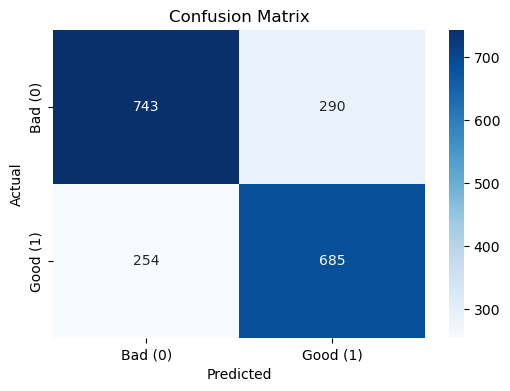

In [120]:
# Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Decision Tree

In [121]:
# Do the split once and capture all outputs
X_train_t_tr, X_train_t_val, Y_train_t_tr, Y_train_t_val = train_test_split(
    X_train_s, 
    y_train_s, 
    test_size=0.25, 
    random_state=42,
)

# Verify the shapes
print('Training set shape:', X_train_t_tr.shape)
print('Validation set shape:', X_train_t_val.shape)
print('Training labels shape:', Y_train_t_tr.shape)
print('Validation labels shape:', Y_train_t_val.shape)

# Verify the proportions
print('\nSplit proportions:')
total_samples = len(X_train_s)
print(f'Training: {len(X_train_t_tr)/total_samples:.2f}')
print(f'Validation: {len(X_train_t_val)/total_samples:.2f}')

Training set shape: (6141, 5)
Validation set shape: (2047, 5)
Training labels shape: (6141,)
Validation labels shape: (2047,)

Split proportions:
Training: 0.75
Validation: 0.25


In [122]:
# check the shape

print('The shape of X_train_t_tr:', X_train_t_tr.shape)
print('The shape of X_train_t_val', X_train_t_val.shape)
print('The shape of Y_train_t_tr:', Y_train_t_tr.shape)
print('The shape of Y_train_t_val:', Y_train_t_val.shape)

The shape of X_train_t_tr: (6141, 5)
The shape of X_train_t_val (2047, 5)
The shape of Y_train_t_tr: (6141,)
The shape of Y_train_t_val: (2047,)


Validation set approach: 

- We use 60% of the data to train models (X_train_t_tr, Y_train_t_tr)
- We use 20% of the data for model selection (X_train_t_val, Y_train_t_val)
- We use the remaining 20% for final evaluation (X_test_transformed, Y_test)

In [123]:
from sklearn import tree, linear_model, neighbors

clf_tree = tree.DecisionTreeClassifier().fit(X_train_t_tr, Y_train_t_tr)
clf_log_reg = linear_model.LogisticRegression(max_iter=10000).fit(X_train_t_tr, Y_train_t_tr)
clf_knn = neighbors.KNeighborsClassifier().fit(X_train_t_tr, Y_train_t_tr)

In [124]:
from sklearn.metrics import accuracy_score

print('Decision tree accuracy: %3f'%accuracy_score(Y_train_t_val, clf_tree.predict(X_train_t_val)))
print('Logistic regression accuracy: %3f'%accuracy_score(Y_train_t_val, clf_log_reg.predict(X_train_t_val)))
print('KNN accuracy: %.3f'%accuracy_score(Y_train_t_val, clf_knn.predict(X_train_t_val)))


Decision tree accuracy: 0.843185
Logistic regression accuracy: 0.718124
KNN accuracy: 0.832


In [125]:
from sklearn.model_selection import cross_validate
from sklearn import tree, linear_model, neighbors

cv_result_tree = cross_validate(tree.DecisionTreeClassifier(), X_train_s, y_train_s, cv=5, return_estimator=True)
cv_result_log_reg = cross_validate(linear_model.LogisticRegression(max_iter=10000), X_train_s, y_train_s, cv=5, return_estimator=True)
cv_result_knn = cross_validate(neighbors.KNeighborsClassifier(), X_train_s, y_train_s, cv=5, return_estimator=True)

In [126]:
cv_result_tree

{'fit_time': array([0.05178881, 0.02124786, 0.01644492, 0.01693106, 0.01768112]),
 'score_time': array([0.00788021, 0.0031662 , 0.0022552 , 0.00372696, 0.00240898]),
 'estimator': [DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier(),
  DecisionTreeClassifier()],
 'test_score': array([0.85103785, 0.85958486, 0.83638584, 0.84667074, 0.85827734])}

In [127]:
# this the average value of each model
print('Classification tree - CV accuracy score is %.3f'%cv_result_tree['test_score'].mean())
print('Logistic regression - CV accuracy score %.3f'%cv_result_log_reg['test_score'].mean())
print('KKN - CV accuracy score %.3f'%cv_result_knn['test_score'].mean())

Classification tree - CV accuracy score is 0.850
Logistic regression - CV accuracy score 0.725
KKN - CV accuracy score 0.840


In [128]:

from sklearn.model_selection import GridSearchCV

param_grid = [{'max_depth':[1,2,3,4,5],  
               'criterion':["gini", "entropy"],            
               'min_samples_split':[2,5,10],              
               'min_samples_leaf':[10,20,30]
}]

clf_tree = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(clf_tree, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5],
                          'min_samples_leaf': [10, 20, 30],
                          'min_samples_split': [2, 5, 10]}],
             scoring='accuracy')

In [129]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)

0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 2}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 5}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10, 'min_samples_split': 10}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 2}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 5}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 20, 'min_samples_split': 10}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 30, 'min_samples_split': 2}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 30, 'min_samples_split': 5}
0.8083780191145525 {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 30, 'min_samples_split': 10}
0.8039808040174474 {'criterion': 'gini', 'max_depth'

In [130]:
# the best hyper-parameters we found so far

grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [131]:
# variable holding the best classifier (fitted on the entire dataset)

grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

- Now we are training a model on the train set to evaluate on the validation set

In [132]:
clf_tree = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=10).fit(X_train_t_tr, Y_train_t_tr)

In [133]:
from sklearn.metrics import confusion_matrix

y_pred = clf_tree.predict(X_train_t_val)
conf_matrix = confusion_matrix(Y_train_t_val, y_pred)

print(conf_matrix)

[[956  87]
 [176 828]]


In [134]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

tn, fp, fn, tp = conf_matrix[0,0], conf_matrix[0,1], conf_matrix[1,0], conf_matrix[1,1]

accuracy = (tn + tp)/ (tn + tp + fn + fp)

tpr = tp/ (tp + fn)
fpr = fp/ (fp + tn)
tnr = tn/ (tn + fp)
fnr = fn/ (fn + tp)

recall = recall_score(Y_train_t_val, clf_tree.predict(X_train_t_val))
precision = precision_score(Y_train_t_val, clf_tree.predict(X_train_t_val))

print('tn is %.3f'%tn)
print('fp is %.3f'%fp)
print('fn is %.3f'%fn)
print('tp is %.3f'%tp)
print('tpr is %.3f'%tpr)
print('fpr is %f'%fpr)
print('tnr is %f'%tnr)
print('fnr is %f'%fnr)
print('Recall is %.3f'%recall)
print('Precision is %f'%precision)
print('Accuracy is %f'%accuracy)
# Additional metrics that might be useful
f1_scores = 2 * (precision * tpr) / (precision + tpr)
print(f'F1 Score is {f1_scores:.3f}')

tn is 956.000
fp is 87.000
fn is 176.000
tp is 828.000
tpr is 0.825
fpr is 0.083413
tnr is 0.916587
fnr is 0.175299
Recall is 0.825
Precision is 0.904918
Accuracy is 0.871519
F1 Score is 0.863


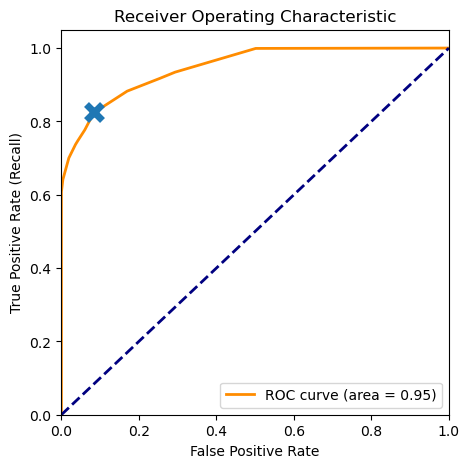

In [135]:
# Plotting the ROC curve for this model

from sklearn import metrics

scores = clf_tree.predict_proba(X_train_t_val)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(Y_train_t_val, scores)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(5,5))
lw = 2

idx = (np.abs(thresholds - 0.5)).argmin()
selected_fpr, selected_tpr = fpr[idx], tpr[idx]

plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.2f)' % auc)
plt.plot([0,1], [0,1], color= 'navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right');

plt.plot(selected_fpr, selected_tpr, marker='x', markeredgewidth=5, markersize=12);


- ROC curve shows a series of models that differ by certain threshold value (on the probability for predicting 1 vs 0)
- 'X' marks the trained model clf_tree

### Using Tree-based models

In [136]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [137]:
# Using the decision stumps (max_depth=1)

clf_tree_1 = DecisionTreeClassifier(max_depth=1, random_state=0).fit(X_train_t_tr, Y_train_t_tr)

In [138]:
train_accuracy_dt = clf_tree_1.score(X_train_t_tr, Y_train_t_tr)
val_accuracy_dt = clf_tree_1.score(X_train_t_val, Y_train_t_val)

print('Train accuracy (DT): %.3f'%train_accuracy_dt)
print('Validation accuracy (DT): %.3f'%val_accuracy_dt)

Train accuracy (DT): 0.816
Validation accuracy (DT): 0.789


   Train accuracy  Validation accuracy
1        0.815502             0.789448
2        0.815502             0.789448
3        0.856212             0.851979
4        0.867774             0.856864
5        0.877707             0.871519
Axes(0.125,0.11;0.775x0.77)


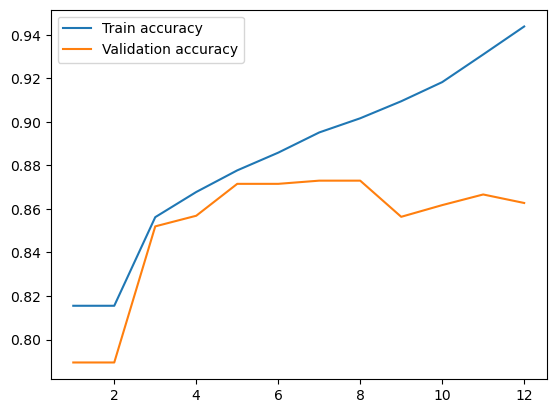

In [139]:
# changing the depth of tree

accuracy_tr = {'Train accuracy':[], 'Validation accuracy':[]}

for depth in range (1,13):
    clf_tr = DecisionTreeClassifier(max_depth= depth, random_state=0)
    clf_tr.fit(X_train_t_tr, Y_train_t_tr)

    acc_train = clf_tr.score(X_train_t_tr, Y_train_t_tr)
    acc_val = clf_tr.score(X_train_t_val, Y_train_t_val)

    accuracy_tr['Train accuracy'].append(acc_train)
    accuracy_tr['Validation accuracy'].append(acc_val)

tree_accuracy = pd.DataFrame(accuracy_tr, index= range(1,13))

print(tree_accuracy.head())
print(tree_accuracy.plot())

Based on this plotting of the train and validation accuracies as the tree depth, we can conclude that there is no improvement of the validation accuracy (shown in the deterioration at some point) in the meanwhile the train accuracy keep improving. ==> This is an indication of overfitting.

- Now, we are trying to tune the hyperparameters of the model to improve its performance.

In [140]:
param_grid_1 = [{'max_depth': range(1,13),
                 'min_samples_leaf': [10,20,100],
                 'max_leaf_nodes': [2,4,6,20,100,10000]}]

grid_search_1 = GridSearchCV(DecisionTreeClassifier(random_state=0),
                             param_grid_1,
                             cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
                             scoring='accuracy')

grid_search_1.fit(X_train_t_tr, Y_train_t_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid=[{'max_depth': range(1, 13),
                          'max_leaf_nodes': [2, 4, 6, 20, 100, 10000],
                          'min_samples_leaf': [10, 20, 100]}],
             scoring='accuracy')

In [141]:
# Creating the datafram based on the results of the grid search above

grid_search_1_res = grid_search_1.cv_results_

tree_accuracy_grid = pd.DataFrame({
    'max_depth': grid_search_1_res['param_max_depth'].data,
    'max_leaf_nodes': grid_search_1_res['param_max_leaf_nodes'].data,
    'min_samples_leaf': grid_search_1_res['param_min_samples_leaf'].data,
    'Accuracy': grid_search_1_res['mean_test_score']
})

print(tree_accuracy_grid.head())

  max_depth max_leaf_nodes min_samples_leaf  Accuracy
0         1              2               10  0.814036
1         1              2               20  0.814036
2         1              2              100  0.814036
3         1              4               10  0.814036
4         1              4               20  0.814036


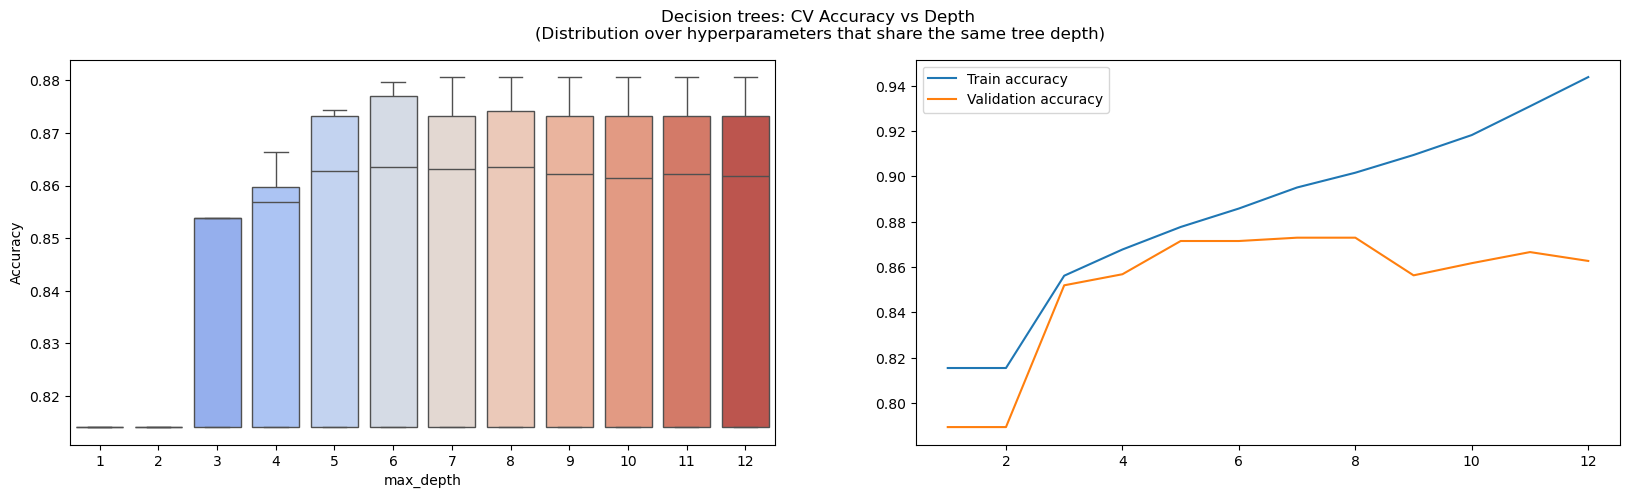

In [142]:
import seaborn as sns 

fig, axes = plt.subplots(1,2, figsize=(20,5))
plt.suptitle('Decision trees: CV Accuracy vs Depth \n(Distribution over hyperparameters that share the same tree depth)')
sns.boxplot(x='max_depth', y='Accuracy', data=tree_accuracy_grid, ax=axes[0], palette='coolwarm');
tree_accuracy.plot(ax=axes[1]);

The figure above shows the cross validation accuracy as a function of the maximal depth. The right tuning can miltigate overfitting.

### Using Ensemble methods - Random forests model

In [143]:
rf = RandomForestClassifier(max_depth=1, random_state=0).fit(X_train_s, y_train_s)
rf

RandomForestClassifier(max_depth=1, random_state=0)

In [144]:
random_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(10, 50, 5),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']}

In [145]:
random_search = RandomizedSearchCV(rf, param_distributions=random_grid, 
                                   n_iter=20, cv=5, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_s, y_train_s)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   2.6s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   2.7s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   5.6s
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_sam

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=1,
                                                    random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([1, 2, 3, 4]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=42, scoring='f1', verbose=2)

In [146]:
best_rf_model_random = random_search.best_estimator_
best_rf_model_random

RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=6, n_estimators=700, random_state=0)

In [147]:
from sklearn.metrics import f1_score


# Predictions on Test Set
y_pred_rf_random = best_rf_model_random.predict(X_test)

# Evaluate Performance
accuracy_random = accuracy_score(y_test, y_pred_rf_random)
precision_random = precision_score(y_test, y_pred_rf_random)
recall_random = recall_score(y_test, y_pred_rf_random)
f1_random = f1_score(y_test, y_pred_rf_random)

print("Best Hyperparameters (via Random Search):", random_search.best_params_)
print("Tuned Random Forest Performance (Randomized Search):")
print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1 Score: {f1_random:.4f}")

Best Hyperparameters (via Random Search): {'n_estimators': 700, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 25, 'class_weight': 'balanced_subsample'}
Tuned Random Forest Performance (Randomized Search):
Accuracy: 0.8818
Precision: 0.9002
Recall: 0.8456
F1 Score: 0.8720


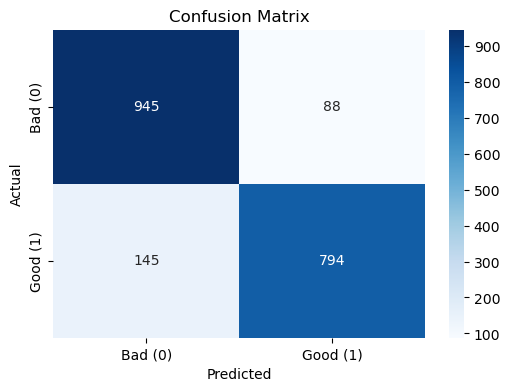

In [148]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_rf_random)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

As the graph above is given, we observe that the performance of the ensemble tends to improve and stablize as the ensembe grows.

### Using Ensemble method - Boosting model

In [149]:
clf_boosting = AdaBoostClassifier(random_state=0).fit(X_train_s, y_train_s)
clf_boosting

AdaBoostClassifier(random_state=0)

In [150]:
train_boosting_acc = clf_boosting.score(X_train_s, y_train_s)
val_boosting_acc = clf_boosting.score(X_train_s, y_train_s)

In [151]:
print('Train accuracy (boosting): %.3f'%train_boosting_acc)
print('Validation accuracy (boosting): %.3f'%val_boosting_acc)

Train accuracy (boosting): 0.874
Validation accuracy (boosting): 0.874


Now, we are testing the effect of the learning rate with higher learning rate and a larger ensemble because the smaller the learning rate, the more iterations we may need to reach the optimal ensemble.

In [152]:
import warnings
warnings.filterwarnings("ignore")

# Initialize AdaBoost with a base Decision Tree (stump)
b_estimator = DecisionTreeClassifier(max_depth=1)
clf_boosting = AdaBoostClassifier(estimator=b_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Train the model
clf_boosting.fit(X_train_s, y_train_s)

# Predictions
y_train_pred = clf_boosting.predict(X_train_s)
y_test_pred = clf_boosting.predict(X_test)

# Performance Metrics
train_acc = accuracy_score(y_train_s, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train_s, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Train F1 Score: {train_f1:.3f}")
print(f"Test F1 Score: {test_f1:.3f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Feature Importance
feature_importance = clf_boosting.feature_importances_
print("Feature Importance:\n", feature_importance)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
    "estimator__max_depth": [1, 2, 3]  # Tuning weak learner depth
}

grid_search = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier()), param_grid, cv=5, scoring="f1")
grid_search.fit(X_train_s, y_train_s)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Train Accuracy: 0.874
Test Accuracy: 0.876
Train F1 Score: 0.870
Test F1 Score: 0.867
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1033
           1       0.89      0.84      0.87       939

    accuracy                           0.88      1972
   macro avg       0.88      0.87      0.88      1972
weighted avg       0.88      0.88      0.88      1972

Feature Importance:
 [0.5  0.   0.06 0.02 0.42]
Best Hyperparameters: {'estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 50}
Best F1 Score: 0.8778658075783244


In [153]:
# Predictions on test data
y_test_pred_ada = clf_boosting.predict(X_test)
accuracy_boosting = accuracy_score(y_test, y_test_pred)
precision_boosting = precision_score(y_test, y_test_pred)
recall_boosting = recall_score(y_test, y_test_pred)
f1_boosting = grid_search.best_score_
print(f"Accuracy (Boosting): {accuracy_boosting:.4f}")
print(f"Precision (Boosting): {precision_boosting:.4f}")
print(f"Recall (Boosting): {recall_boosting:.4f}")
print(f"Best F1 Score: {f1_boosting:.4f}")

Accuracy (Boosting): 0.8763
Precision (Boosting): 0.8900
Recall (Boosting): 0.8445
Best F1 Score: 0.8779


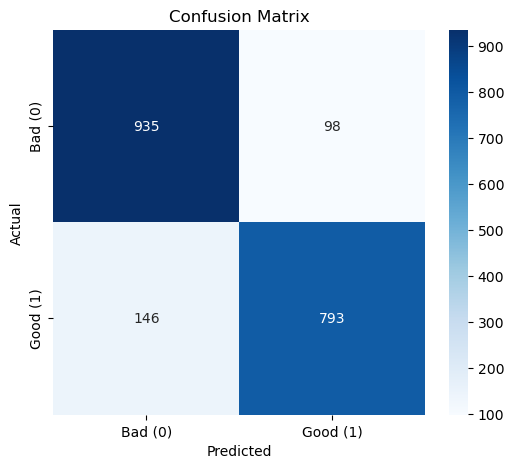

In [154]:
# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

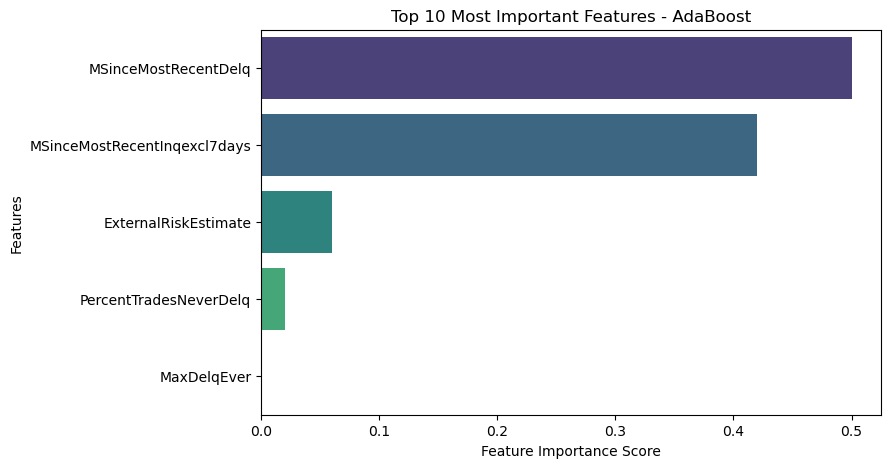

In [155]:
# Extract feature importance from AdaBoost
feature_importance = clf_boosting.feature_importances_

# Create a Pandas Series with feature names
ada_feature_importance = pd.Series(feature_importance, index=X_train.columns)

# Select top 10 most important features
top_features_ada = ada_feature_importance.sort_values(ascending=False).head(10)

# Plot the feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features_ada.values, y=top_features_ada.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Most Important Features - AdaBoost")
plt.show()

XGBoost

In [156]:
# Train XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # Adjust this for imbalanced data
    random_state=42
)

xgb_model.fit(X_train_s, y_train_s)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [157]:
# Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Model Evaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Model Performance:
Accuracy: 0.8895
Precision: 0.9073
Recall: 0.8552
F1 Score: 0.8805

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      1033
           1       0.91      0.86      0.88       939

    accuracy                           0.89      1972
   macro avg       0.89      0.89      0.89      1972
weighted avg       0.89      0.89      0.89      1972



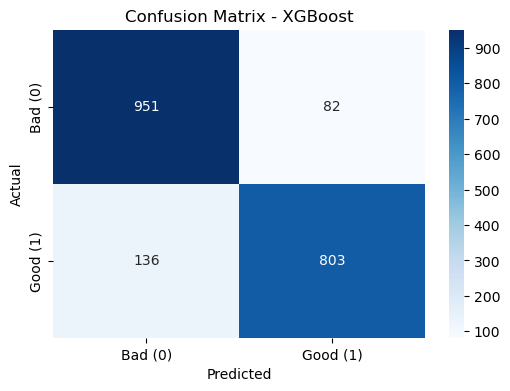

In [158]:
#Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

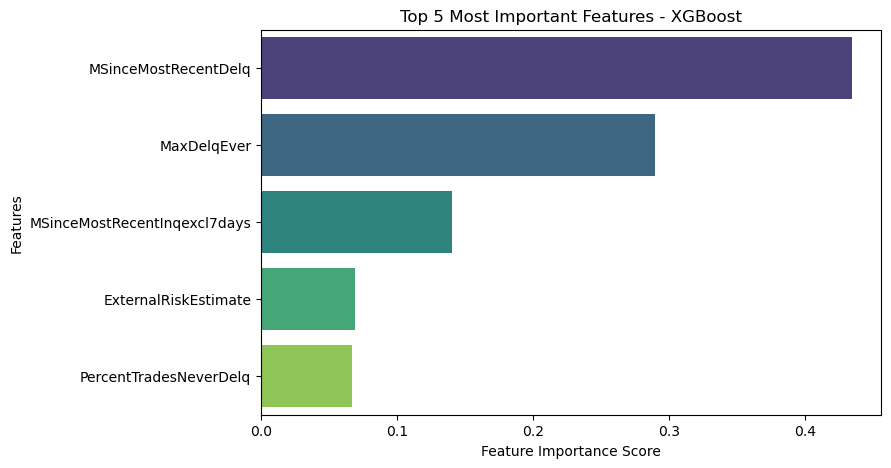

In [159]:
#Feature Importance Visualization
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=selected)
top_features_xgb = xgb_feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features_xgb.values, y=top_features_xgb.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 5 Most Important Features - XGBoost")
plt.show()

In [160]:
model_comparison = {
    "Model": ["XGBoost", "AdaBoost", "Random Forest (Tuned)", "Decision Tree", "Logistic Regression"],
    "Accuracy": [accuracy_xgb, accuracy_boosting, accuracy_random, accuracy, log_accuracy],
    "Precision": [precision_xgb, precision_boosting, precision_random, precision, log_precision],
    "Recall": [recall_xgb, recall_boosting, recall_random, recall, log_recall],
    "F1-Score": [f1_xgb, f1_boosting, f1_random, f1_scores, log_f1]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(model_comparison)
comparison_df

,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.889452,0.907345,0.855165,0.880482
1,AdaBoost,0.876268,0.890011,0.844515,0.877866
2,Random Forest (Tuned),0.881846,0.900227,0.845580,0.872048
3,Decision Tree,0.871519,0.904918,0.824701,0.862949
4,Logistic Regression,0.724138,0.702564,0.729499,0.715778


In [161]:
!pip install joblib

In [162]:
import joblib
joblib.dump(xgb_model, "/Users/annekhieu/Downloads/ML project 2025/XGB_model.pkl")

['/Users/annekhieu/Downloads/ML project 2025/XGB_model.pkl']